# Submesoscale Fronts

The notebook implements the detection algorithm for submesoscale fronts (chapter 2.4). Further, it creates figures to visualize the appearance of submesoscale fronts (chapter 3.2.1) and the detection results (chapter 3.2.2). The following figures are created in this notebook:
- Figure 3.7: Snapshot of submesoscale fronts in HR
- Figure 3.8: Snapshot of submesoscale fronts in MR
- Figure 3.9: Vertical section of submesoscale fronts
- Figure 3.10: Instabilities in submesoscale fronts
- Figure 3.11: Area covered by submesoscale fronts
- Figure A.1: Detection results for HR in winter: I
- Figure A.2: Detection results for HR in winter: II
- Figure A.3: Detection results for HR in winter: III
- Figure A.4: Detection results for HR in summer
- Figure A.5: Detection results for MR in winter: I
- Figure A.6: Detection results for MR in winter: II
- Figure A.7: Detection results for different $\sigma_{lat}$

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts')

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from romstools.romsrun import RomsRun
from romstools.psd import get_dist, prepare_axis_for_psd, plot_single_psd, do_multidim_welch
from romstools.utils import get_depth_dim, np_rolling_mean
from romstools.cmap import W2G
from romstools.plot import plot_data
from romstools.utils import p, cache, mean_with_error, ratio_with_error

import scipy.signal as sig
import scipy.stats as stat

import cartopy.crs as ccrs

import warnings
from datetime import timedelta as tdelta

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.cm import get_cmap


from scipy.ndimage import gaussian_filter
from scipy.ndimage import label

from collections import defaultdict
from matplotlib import cm
from matplotlib.colors import Normalize

## Load Data 

In [2]:
def get_run(directory):
    # create run object
    run = RomsRun('/nfs/kryo/work/maxsimon/data/'+directory+'/grid.nc')
    # load vertical velocity and density
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_d_*.nc', variables=['temp', 'time', 'w', 'rho'])
    # load mixed layer depth (raw and as climatology)
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/d_*.nc', variables=['time', 'hbls'])
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/climatologies/hbls-1d.nc')
    # load position of z levels
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_levels.nc')
    # load vorticity
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/vort.nc')
    # load horizontal velocities (interpolated to rho grid)
    run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_vel.nc')
    
    # load grid data, i.e. the distance map, distance lines and the domain mask
    data = np.load('/nfs/kryo/work/maxsimon/data/'+directory+'/grid.npz', allow_pickle=True)
    run.distance_map = data['distance_map']
    run.distance_lines = data['distance_lines']
    run.gruber_mask = data['gruber_mask']
    
    # this is a map where the area of each eddy instance is filled with its polarity
    # this is useful for calculating overlaps between fronts and eddies
    k = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+directory+'/ssh/final_eddy_attr_map_cyc-int-ampl.nc')
    run.cyc_map = k['tot_cyc_map']
    
    return run

In [3]:
# set up runs
subm = get_run('pactcs15')
meso = get_run('pactcs30')

runs = {
    'pactcs15': subm,
    'pactcs30': meso
}

# define subdomain to be used in detection algorithm
# see below for a visualisation of the subdomain
SUBM_SLICE = (slice(60, 240), slice(400, 700))
MESO_SLICE = (slice(40, 115), slice(170, 280))

## Example Snapshots

### pactcs15

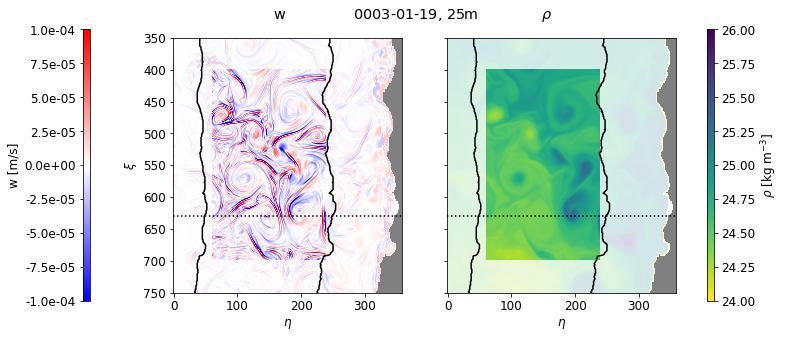

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True) #, subplot_kw={'projection': ccrs.PlateCarree()})

# choose date to plot
t = '0003-01-19'
# choose depth level to plot (25m)
depth_idx = 7

# get vertical velocities
w = subm.w.sel(time=t, method='nearest').isel(time=0, depth=depth_idx)
# get density
v = subm.rho.sel(time=t, method='nearest').isel(time=0, depth=depth_idx)

# plot vertical velocity
_, cax_w = plot_data(subm.grid, w, ax=ax[0], vmin=-1e-4, vmax=1e-4, cmap='bwr', highlight_subdomain=SUBM_SLICE, as_contourfill=False, land_gray=True, colorbar=False, highlight_subdomain_alpha=0.2)
# plot density
_, cax_v = plot_data(subm.grid, v, lon_name='lon_rho', lat_name='lat_rho', ax=ax[1], vmin=24, vmax=26, highlight_subdomain=SUBM_SLICE, as_contourfill=False, land_gray=True, colorbar=False, highlight_subdomain_alpha=0.2, cmap='viridis_r')

for i in range(2):
    # set limits for coordinates
    ax[i].set_ylim(750, 350)
    # plot distance lines
    for line in subm.distance_lines:
        ax[i].plot(line[2], line[3], color='k')
    # add line to mark where the vertical section was taken
    ax[i].axhline(630, color='k', ls=':')    
    
# labels
ax[0].set_title('w   \t\t'+t+', {:.0f}m\t\t     $\\rho$'.format(subm.z_level[depth_idx].item()), x=1.05, y=1.05)
ax[1].set_ylabel('')

# colorbars
plt.colorbar(cax_w[-1], ax=ax, location='left', label='w [m/s]', format='%.1e', aspect=40)
plt.colorbar(cax_v[-1], ax=ax, location='right', label='$\\rho$ [kg m$^{-3}$]', aspect=40)

plt.savefig('figures/result_subm_snapshot-p15.pdf')
plt.show()

### pactcs30

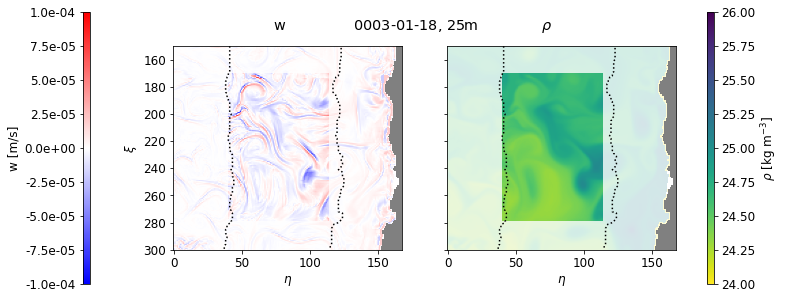

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True) #, subplot_kw={'projection': ccrs.PlateCarree()})

# choose date to plot
t = '0003-01-18'
# choose depth level to plot (25m)
depth_idx = 7

# get vertical velocities
w = meso.w.sel(time=t, method='nearest').isel(time=0, depth=depth_idx)
# get density
v = meso.rho.sel(time=t, method='nearest').isel(time=0, depth=depth_idx)

# plot vertical velocity
_, cax_w = plot_data(meso.grid, w, ax=ax[0], vmin=-1e-4, vmax=1e-4, cmap='bwr', highlight_subdomain=MESO_SLICE, as_contourfill=False, land_gray=True, colorbar=False, highlight_subdomain_alpha=0.2)
# plot density
_, cax_v = plot_data(meso.grid, v, lon_name='lon_rho', lat_name='lat_rho', ax=ax[1], vmin=24, vmax=26, highlight_subdomain=MESO_SLICE, as_contourfill=False, land_gray=True, colorbar=False, highlight_subdomain_alpha=0.2, cmap='viridis_r')


for i in range(2):
    # set limits for coordinates
    ax[i].set_ylim(300, 150)
    # plot distance lines
    for line in meso.distance_lines:
        ax[i].plot(line[2], line[3], ls=':', color='k')
    
# labels
ax[0].set_title('w   \t\t'+t+', {:.0f}m\t\t     $\\rho$'.format(meso.z_level[depth_idx].item()), x=1.05, y=1.05)
ax[1].set_ylabel('')

# colorbars
plt.colorbar(cax_w[-1], ax=ax, location='left', label='w [m/s]', format='%.1e', aspect=40)
plt.colorbar(cax_v[-1], ax=ax, location='right', label='$\\rho$ [kg m$^{-3}$]', aspect=40)

plt.savefig('figures/result_subm_snapshot-p30.pdf')
plt.show()

### Vertical Section in pactcs15

In [6]:
def plot_vertical_slice(run, t_obj, rho_slice, xi_idx_, path=''):
    """
    Function to plot a vertical section through domain. t_obj defines the date, rho_slice the subdomain. xi_idx is the index in xi coordinates to be used for the slice
    """
    
    xi_idx = xi_idx_-rho_slice[1].start
    
    # get time object and doy
    t_obj = run.time.sel(time=t_obj, method='nearest').values.item()
    doy = t_obj.dayofyr - 1
    
    # get vertical velocity w
    w = run.w.sel(time=t_obj, method='nearest').isel(eta_rho=rho_slice[0], xi_rho=rho_slice[1]).values[:, :, xi_idx]
    
    # get position of cyclones and anticyclones
    cyc_map = run.cyc_map.sel(time=t_obj, method='nearest').values[rho_slice]
    # we need to have it as image data in order to plot it later...
    cyc_data = np.zeros_like(w) * np.nan
    cyc_data[:2, :] = cyc_map[:, xi_idx][None, :]
    cyc_data[cyc_data == 0] = np.nan
    
    # get mixed layer depth
    hb = run.hbls.sel(time=t_obj, method='nearest').values[rho_slice][:, xi_idx]
    # we plot everything in depth-index space, therefore this needs to be converted to depth indices
    hb = np.interp(hb, run.z_level.values, np.arange(run.z_level.shape[0]).astype(float))
    
    # get density
    rho = run.rho.sel(time=t_obj, method='nearest').isel(eta_rho=rho_slice[0], xi_rho=rho_slice[1]).values[:, :, xi_idx]
    
    # create figure
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    
    # plot vertical velocity
    cax = ax.matshow(w, vmin=-1e-4, vmax=1e-4, cmap='bwr', aspect='auto')
    # plot cyclones and anticyclones    
    cax_cyc = ax.matshow(cyc_data, vmin=0.75, vmax=2.25, cmap='PiYG', aspect='auto')
    # plot mixed layer depth
    ax.plot(hb, color='k')
    # plot density as isopycnals
    ax.contour(rho, vmin=25, vmax=27, levels=[24.4, 24.5, 24.6, 24.7, 24.8, 24.9, 25.0], linestyles=':', linewidths=2)
    
    # set depth to plot
    ax.set_ylim(26, 0)
    
    # set y ticks and labels (depth)
    yticks = np.array([0, 7, 12, 22])
    yticklabels = ["{:.0f}".format(a) for a in run.z_level.values[yticks]]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel('Depth [m]')
    
    # set x ticks and labels (distance to coast)
    xdistances = np.array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]).astype(float)[::-1]
    distances = run.distance_map[rho_slice][:, xi_idx][::-1]
    xticks = np.interp(xdistances, distances, np.arange(distances.shape[0]).astype(float)[::-1])
    ax.set_xticks(xticks)
    ax.set_xticklabels(["{:.0f}".format(a) for a in xdistances])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Distance from coast [km]')
    
    ax.set_title('{:s}, $\\xi = {:d}$'.format(str(t_obj), xi_idx_))
    
    # add colorbar
    plt.colorbar(cax, orientation='vertical', label='w [m/d]', aspect=30, format='%.1e')
    
    if path != '':
        plt.savefig(path)
    
    plt.show()

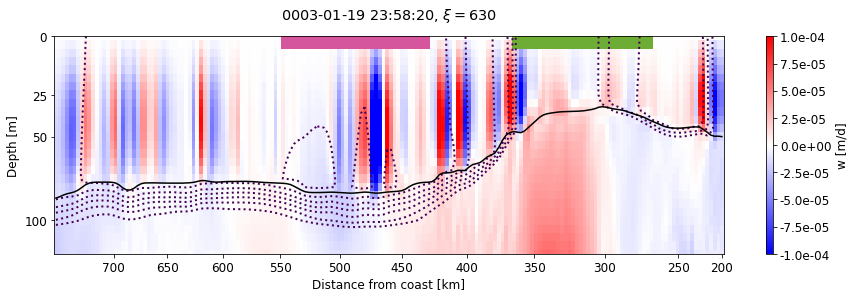

In [7]:
plot_vertical_slice(subm, '0003-01-19', SUBM_SLICE, 630, path='figures/result_snapshot-vert-p15.pdf')

### Frontal Instabilities in pactcs15

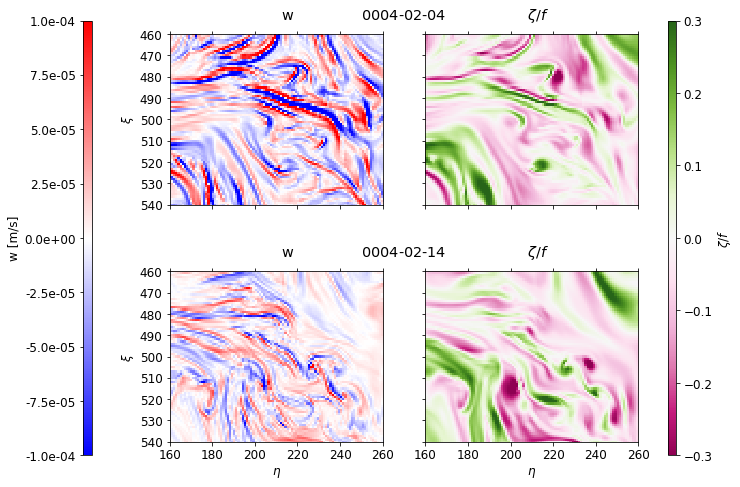

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex='col', sharey='row')

# save for colorbar
cax1 = None
cax2 = None

for i, d in enumerate(('0004-02-04', '0004-02-14')):
    # get vertical velocity
    w = subm.w.sel(time=d, method='nearest').isel(time=0, depth=7).values
    # get relative vorticity
    rvort = subm.rvort.sel(time=d, method='nearest').isel(time=0, depth=7).values
    # get planetary vorticity (it is on another grid, thats why we have to drop one item)
    f = subm.grid.f.isel(eta_rho=slice(0, -1), xi_rho=slice(0, -1)).values
    
    # plot vertical velocity
    cax1 = ax[i, 0].matshow(w.T, cmap='bwr', vmin=-1e-4, vmax=1e-4)
    # plot rossby
    cax2 = ax[i, 1].matshow((rvort/f).T, vmin=-.3, vmax=.3, cmap='PiYG')
    
    # label
    ax[i, 0].set_title('w      \t\t'+d+'\t\t    $\\zeta/f$', x=1.15)
    ax[i, 0].set_ylabel('$\\xi$')
    
    for j in range(2):
        # set ranges
        ax[i, j].set_ylim(540, 460)
        ax[i, j].set_xlim(160, 260)
        
        # add x label
        if i == 1:
            ax[i, j].tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
            ax[i, j].set_xlabel('$\\eta$')
            
# add colorbars
plt.colorbar(cax1, ax=ax, label='w [m/s]', format='%.1e', location='left', aspect=50)
plt.colorbar(cax2, ax=ax, label='$\\zeta/f$', location='right', aspect=50)

plt.savefig('figures/result_snapshot_instabilities.pdf')
plt.show()

## Detection Algorithm

In [9]:
def get_bbox(bool_map):
    """
    Get a bounding box for a boolean map.
    """
    bm1 = np.sum(bool_map, axis=0) > 0
    bm0 = np.sum(bool_map, axis=1) > 0
    start0 = np.argmax(bm0)
    end0 = bool_map.shape[0] - np.argmax(bm0[::-1])
    start1 = np.argmax(bm1)
    end1 = bool_map.shape[1] - np.argmax(bm1[::-1])
    return (slice(start0, end0), slice(start1, end1))


def detect_submesoscale_fronts(run, t_obj, rho_slice, sigma=2, num_covering_pixel=10):
    """
    Perform detection of submesoscale fronts on run object. t_obj defines the time, rho_slice the subdomain to use. sigma is used for thresholding and num_covering_pixels for removing noise (see thesis for details on the algorithm).
    """
    
    # get w
    w = run.w.sel(time=t_obj, method='nearest').isel(eta_rho=rho_slice[0], xi_rho=rho_slice[1]).values.copy()
    w = np.squeeze(w)
    # calculat w_smooth and wdiff
    wsmooth = gaussian_filter(w, sigma=(0, sigma, sigma))
    wdiff = w - wsmooth
    
    # calculate threshold for w
    threshold = np.nanmean(np.abs(wsmooth), axis=(1, 2))
    
    # connected components on each depth
    data = np.zeros_like(w)
    
    for depth_idx in range(w.shape[0]):
        # 2D connected components for upwelling
        labels_pos, num_labels_pos = label(wdiff[depth_idx] >= 2*threshold[depth_idx, None, None])
        # 2D connected components for downwelling
        labels_neg, num_labels_neg = label(wdiff[depth_idx] <= -2*threshold[depth_idx, None, None])
        # combine labels (upwelling positive, downwelling negative)
        labels = labels_pos - labels_neg
        
        all_labels = np.unique(labels)
        # do some consistency tests
        assert np.unique(labels_pos).shape[0] + np.unique(labels_neg).shape[0] == all_labels.shape[0] + 1
        assert np.count_nonzero(labels_pos) + np.count_nonzero(labels_neg) == np.count_nonzero(labels), (
            np.count_nonzero(labels_pos), np.count_nonzero(labels_neg), np.count_nonzero(labels), num_labels_pos
        )
        
        # loop all detected connected components
        for l in all_labels:
            
            # this is background
            if l == 0:
                continue
            
            # create a boolean mask for this components
            mask = labels == l
            num_items = np.count_nonzero(mask)  # number of pixels in the component
            
            # require minimum number of connected components
            if num_items < num_covering_pixel:
                continue
            
            # minimum fraction of number of pixels to bbox area
            bbox = get_bbox(mask)
            bbox_area = (bbox[1].stop - bbox[1].start) * (bbox[0].stop - bbox[0].start)
            if num_items/bbox_area > 0.5:
                continue
                
            # add component for further processing
            data[depth_idx, mask] = l
            
    
    # do a 3D connected component analysis
    labels_pos, num_labels_pos = label(data > 0)  # ... for upwelling
    labels_neg, num_labels_neg = label(data < 0)  # ... for downwelling
    labels = labels_pos - labels_neg  # see above
    
    all_labels = np.unique(labels)
    # do some consistency tests
    assert np.unique(labels_pos).shape[0] + np.unique(labels_neg).shape[0] == all_labels.shape[0] + 1
    assert np.count_nonzero(labels_pos) + np.count_nonzero(labels_neg) == np.count_nonzero(labels)
            
    data2 = np.zeros_like(data)
    num_components = 0  # counter for number of components
    
    # loop all components
    for l in all_labels:
        
        # background
        if l == 0:
            continue
        mask = labels == l
        
        # make sure that it extends at least 5 depth levels
        depth_map = np.count_nonzero(mask, axis=0)
        assert depth_map.shape == w.shape[1:]
        if np.max(depth_map) < 5:
            continue
        
        # add to final set of detected fronts
        num_components += 1
        data2[mask] = l
        
    return w, data2, num_components

## Evaluating the Detection Algorithm

In [10]:
def plot_evaluation(run, t_obj_orig, rho_slice, path='', depth_idxs=[5, 10, 15], **kwargs):
    """
    Function to perform the detection algorithm and to plot the results.
    """
    # perform detection
    w, data, num_components = detect_submesoscale_fronts(run, t_obj_orig, rho_slice, **kwargs)
    
    # get time object
    t_obj = run.time.sel(time=t_obj_orig, method='nearest').values.item()
    doy = t_obj.dayofyr - 1
    
    fig, ax = plt.subplots(len(depth_idxs), 2, figsize=(12, 4+len(depth_idxs)*3), sharex=True, sharey=True)
    
    if len(depth_idxs) == 1:
        ax = np.array([ax])
    
    cax = None
    
    # for each depth idx...
    for i, depth_idx in enumerate(depth_idxs):
        # plot w
        cax = ax[i, 0].imshow(w[depth_idx], vmin=-1e-4, vmax=1e-4, cmap='bwr') #, aspect='auto')
        # plot detection
        ax[i, 1].imshow(data[depth_idx], vmin=-1e-4, vmax=1e-4, cmap='bwr') #, aspect='auto')
        
        # set labels and title
        ax[i, 0].set_ylabel('$\\eta$')
        ax[i, 0].set_title('w, {:s}, {:.0f}m'.format(str(t_obj_orig), run.z_level[depth_idx].values.item()))
        ax[i, 1].set_title('detections, {:s}, {:.0f}m'.format(str(t_obj_orig), run.z_level[depth_idx].values.item()))
        
    # labels
    ax[-1, 0].set_xlabel('$\\xi$')
    ax[-1, 1].set_xlabel('$\\xi$')
    
    plt.colorbar(cax, ax=ax, label='w [m/s]', format='%.1e', location='bottom', aspect=50)
    
    if path != '':
        plt.savefig(path)
    
    plt.show()

#### Detection Performance in pactcs15 in winter vs in summer

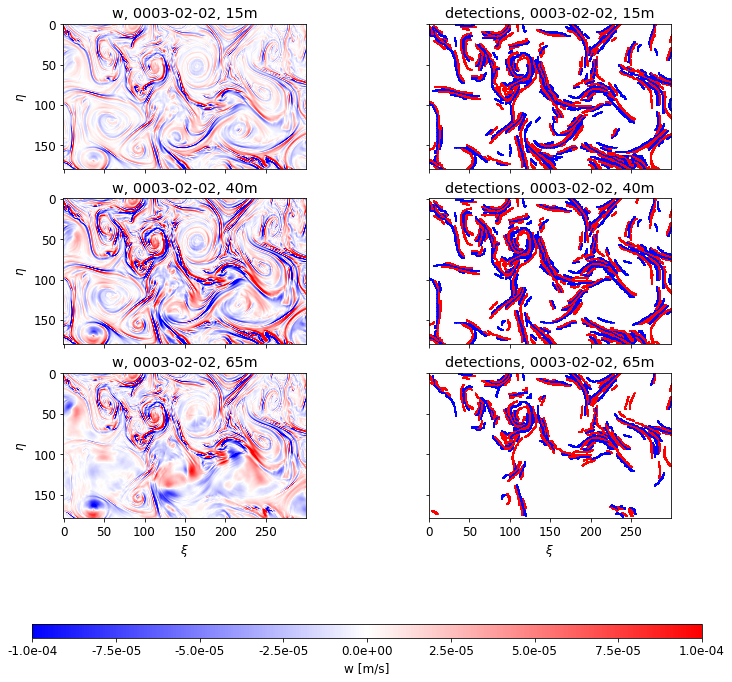

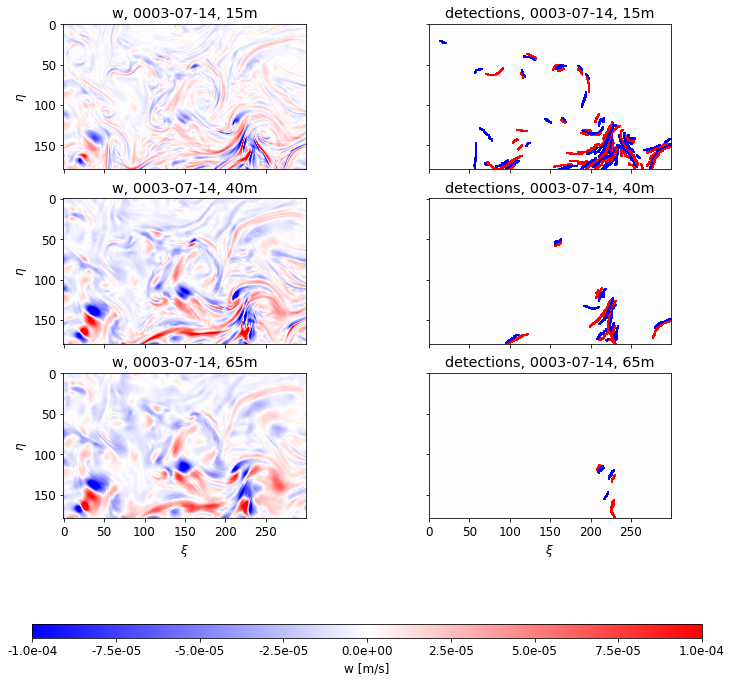

In [11]:
plot_evaluation(subm, '0003-02-02', SUBM_SLICE, path='figures/eval_det_subm_winter.pdf')
plot_evaluation(subm, '0003-07-14', SUBM_SLICE, path='figures/eval_det_subm_summer.pdf')

The algorithm successfully adjusts to the number of present fronts, i.e. there are fewer detections when there are fewer fronts.

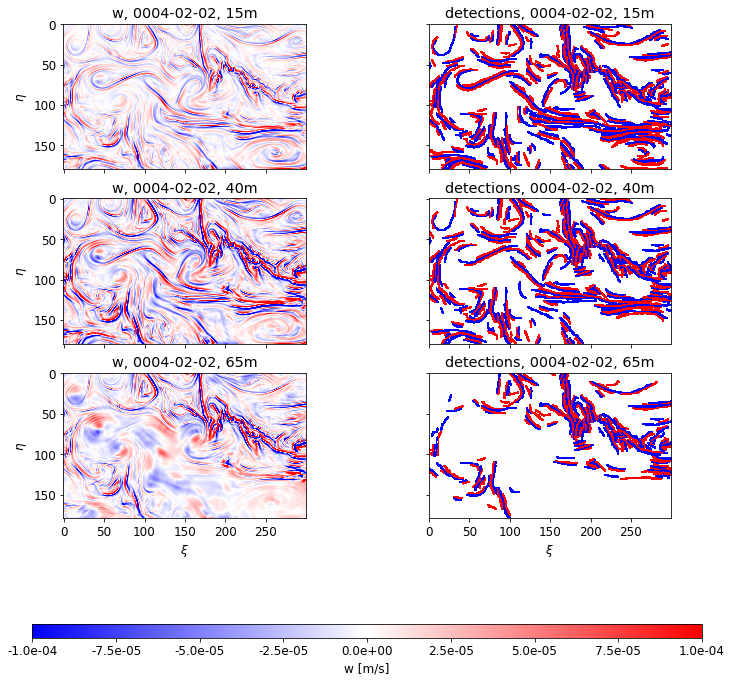

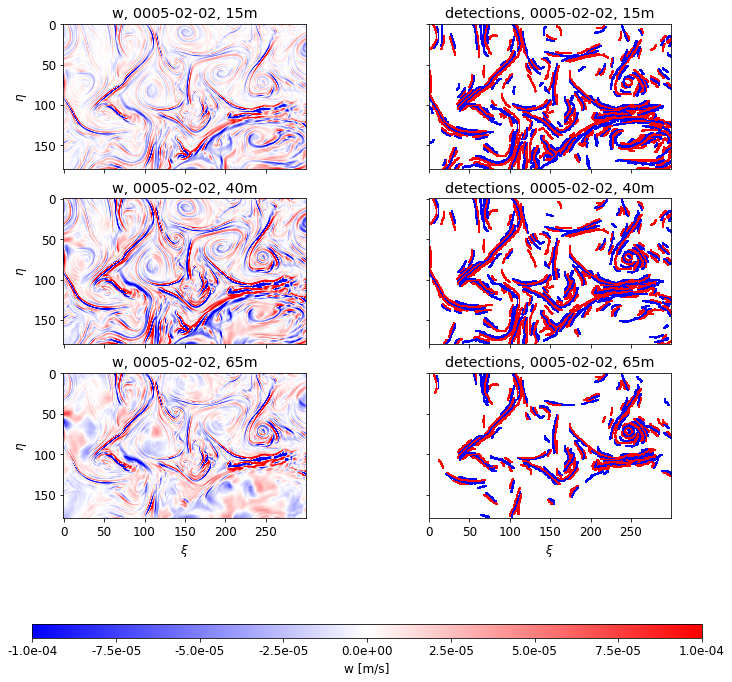

In [12]:
plot_evaluation(subm, '0004-02-02', SUBM_SLICE, path='figures/eval_det_subm_winter2.pdf')
plot_evaluation(subm, '0005-02-02', SUBM_SLICE, path='figures/eval_det_subm_winter3.pdf')

#### pactcs30 vs pactcs15

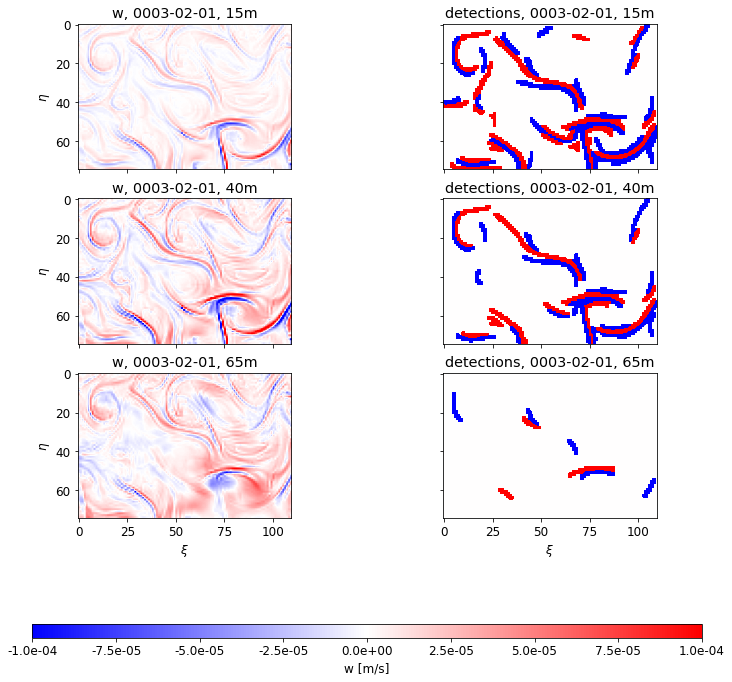

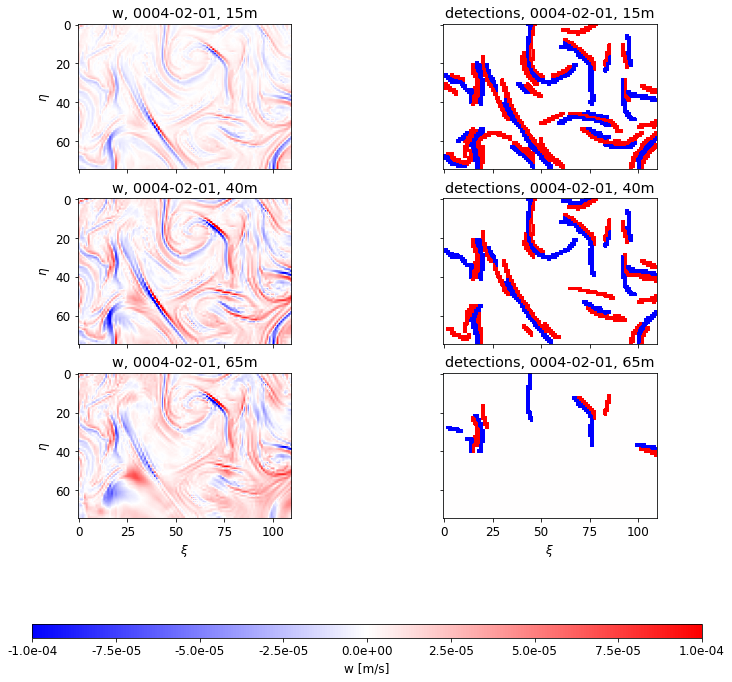

In [13]:
plot_evaluation(meso, '0003-02-01', MESO_SLICE, path='figures/eval_det_meso_winter.pdf')
plot_evaluation(meso, '0004-02-01', MESO_SLICE, path='figures/eval_det_meso_winter2.pdf')

The detection algorithm also detects fronts in pactcs30. However, there are less fronts in pactcs30.

#### Impact of parameter sigma

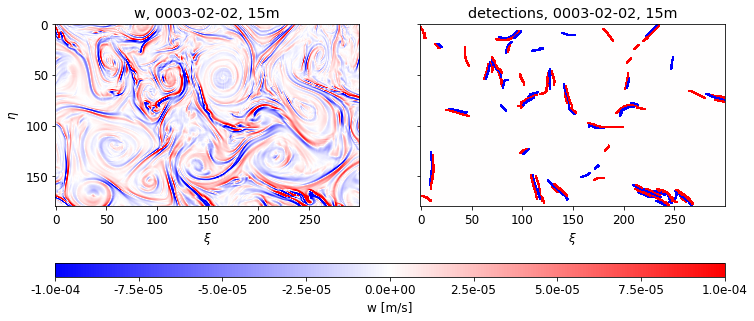

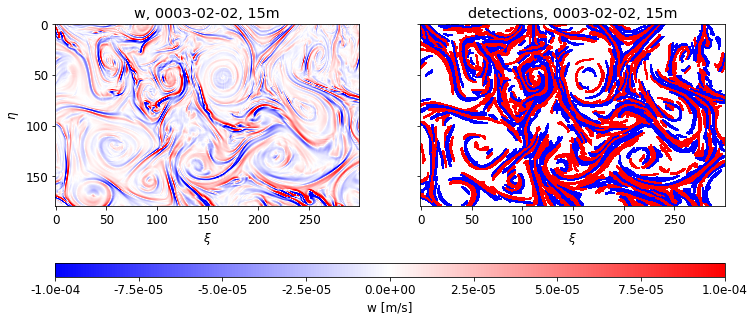

In [14]:
plot_evaluation(subm, '0003-02-02', SUBM_SLICE, depth_idxs=[5], sigma=1, path='figures/eval_det_sig_sm.pdf')
plot_evaluation(subm, '0003-02-02', SUBM_SLICE, depth_idxs=[5], sigma=4, path='figures/eval_det_sig_lg.pdf')

The parameter `sigma` modulates the number of detected fronts. It implicitly sets the width/strength of features that are detected.

## Application to data

In [15]:
def scan_run_data(name, rho_slice, **kwargs):
    """
    Applies the detection algorithm to a run object on a given subdomain (rho_slice) and keeps track of some statistics (see list below).
    """
    
    # get run
    run = runs[name]
    
    # data we want to track
    daily_doy_data = {
        key: defaultdict(list) for key in (
            'area_up', # area associated to upward fronts
            'area_down', # area associated to downward fronts
            'area_up_cycl', # area associated to upward fronts in cyclones
            'area_down_cycl', # area associated to downward fronts in cyclones
            'area_up_anti', # area associated to upward fronts in anticyclones
            'area_down_anti', # area associated to downward fronts in anticyclones
            'w_up', # vertical velocity in upward fronts
            'w_down', # vertical velocity in downward fronts
            'area_cycl', # total area of cyclones
            'area_anti' # total area of anticyclones
        )
    }
    
    # get area map
    area_map = run.area_map[rho_slice]
        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    
        # loop timesteps
        for time_index, t_obj in enumerate(run.time.values):
            
            print('Processing', t_obj, end='\r')
            doy = t_obj.dayofyr - 1
            
            # only process years 3, 4 and 5
            if time_index < 364 or time_index > 910:
                continue
            
            # run detection
            w, data, num_components = detect_submesoscale_fronts(run, t_obj, rho_slice, **kwargs)
            
            # get map of cyclones and anticyclones
            cyc_map = run.cyc_map.sel(time=t_obj, method='nearest').values[rho_slice]
            ## get the vertical velocity at depth 25m
            #w = run.w.sel(time=t_obj, method='nearest').isel(depth=7, eta_rho=rho_slice[0], xi_rho=rho_slice[1]).values
            
            # set up arrays to store values from different depths
            area_up = []
            area_down = []
            area_up_cycl = []
            area_down_cycl = []
            area_up_anti = []
            area_down_anti = []
            w_up = []
            w_down = []
            
            # bool mask for cyclones
            cycl_mask = cyc_map == 2
            # bool mask for anticyclones
            anti_mask = cyc_map == 1
            
            # loop depths
            for depth_idx in range(data.shape[0]):
                fronts_mask_up = data[depth_idx] > 0  # mask for upwelling fronts
                fronts_mask_down = data[depth_idx] < 0  # mask for downwelling fronts
                
                # save areas for up and downwelling
                area_up.append(np.nansum(area_map[fronts_mask_up]))
                area_down.append(np.nansum(area_map[fronts_mask_down]))
                
                # save areas conditioned on cyclones
                area_up_cycl.append(np.nansum(
                    area_map[np.logical_and(fronts_mask_up, cycl_mask)]
                ))
                area_down_cycl.append(np.nansum(
                    area_map[np.logical_and(fronts_mask_down, cycl_mask)]
                ))
                
                # save areas conditioned on anticyclones
                area_up_anti.append(np.nansum(
                    area_map[np.logical_and(fronts_mask_up, anti_mask)]
                ))
                area_down_anti.append(np.nansum(
                    area_map[np.logical_and(fronts_mask_down, anti_mask)]
                ))
                
                # save vertical velocities
                w_up.append(np.nanmean(w[depth_idx, fronts_mask_up]))
                w_down.append(np.nanmean(w[depth_idx, fronts_mask_down]))
                
            
            # save data in doy order
            daily_doy_data['area_up'][doy].append(area_up)
            daily_doy_data['area_down'][doy].append(area_down)
            daily_doy_data['area_up_cycl'][doy].append(area_up_cycl)
            daily_doy_data['area_down_cycl'][doy].append(area_down_cycl)
            daily_doy_data['area_up_anti'][doy].append(area_up_anti)
            daily_doy_data['area_down_anti'][doy].append(area_down_anti)
            daily_doy_data['w_up'][doy].append(w_up)
            daily_doy_data['w_down'][doy].append(w_down)
            daily_doy_data['area_cycl'][doy].append(
                np.nansum(area_map[cycl_mask])
            )
            daily_doy_data['area_anti'][doy].append(
                np.nansum(area_map[anti_mask])
            )
            
        # set up a dictionary to store results and error approximations
        res = {}
        for key in daily_doy_data:
            res[key] = []
            res['d_'+key] = []
        
        # loop possible doys
        for doy in range(365):
            # if there is data for this doy...
            if doy in daily_doy_data['area_up']:
                for key in daily_doy_data:
                    # save mean over all data points belonging to doy
                    res[key].append(np.nanmean(daily_doy_data[key][doy], axis=0))
                    # approximate error by taking the range of these values
                    res['d_'+key].append(
                        0.5*(np.nanmax(daily_doy_data[key][doy], axis=0) - np.nanmin(daily_doy_data[key][doy], axis=0))
                    )
        
        # as numpy arrays
        for key in res:
            res[key] = np.array(res[key])

        return res

In [ ]:
## This takes some time. You can skip this by loading the detection results from file (see below)

# apply to pactcs30
meso_res = scan_run_data('pactcs30', rho_slice=MESO_SLICE, num_covering_pixel=4)

# apply to pactcs15
subm_res = scan_run_data('pactcs15', rho_slice=SUBM_SLICE, num_covering_pixel=10)

np.savez('detections_eval.npz', meso_res=meso_res, subm_res=subm_res)

In [16]:
d = np.load('detections_eval.npz', allow_pickle=True)
meso_res = d['meso_res'].item()
subm_res = d['subm_res'].item()

### Asymmetry between upwelling and downwelling

An asymmetry between upwelling and downwelling fronts is expected: the upwelling area should be slightly larger as the downwelling area, whereas the downwelling velocity should be slightly stronger.

In [17]:
def evaluate_asymmetry(res, name, depth_slice=slice(1, 10), time_slice=slice(None, None)):
    # shortlinks
    up = res[name+'_up']
    down = res[name+'_down']
    d_up = res['d_'+name+'_up']
    d_down = res['d_'+name+'_down']
    
    # calculate ratio between data
    rel_area, d_rel_area = ratio_with_error(up, down, d_up, d_down)
    
    print('Up: {:2.3e} + {:2.3e}'.format(*mean_with_error(up[time_slice, depth_slice], d_up[time_slice, depth_slice])))
    print('Down: {:2.3e} + {:2.3e}'.format(*mean_with_error(down[time_slice, depth_slice], d_down[time_slice, depth_slice])))
    print('Up/Down: {:2.3e} + {:2.3e}'.format(*mean_with_error(rel_area[time_slice, depth_slice], d_rel_area[time_slice, depth_slice])))
    return

In [18]:
evaluate_asymmetry(subm_res, 'area')

Up: 2.744e+04 + 7.090e+01
Down: 2.689e+04 + 7.060e+01
Up/Down: 1.031e+00 + 6.129e-03


/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:263: RuntimeWarning: divide by zero encountered in true_divide
  rel = x/y
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:263: RuntimeWarning: invalid value encountered in true_divide
  rel = x/y
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:266: RuntimeWarning: divide by zero encountered in true_divide
  ((dx/y)**2) +
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:266: RuntimeWarning: invalid value encountered in true_divide
  ((dx/y)**2) +
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:267: RuntimeWarning: invalid value encountered in true_divide
  ((dy*x/(y**2))**2)


In [19]:
evaluate_asymmetry(subm_res, 'w')

Up: 3.069e-05 + 9.766e-08
Down: -3.403e-05 + 1.282e-07
Up/Down: -9.112e-01 + 3.674e-03


The upwelling area is $3.1 \pm 0.6\%$ larger as the downwelling area and the downwelling velocity is $8.9 \pm 0.4\%$ larger than the upwelling velocity.

### Coverage in pactcs30 vs pactcs15

In [20]:
# Calculate MLD with a 14 day rolling mean
meso_mld = np_rolling_mean(meso.hbls_b.isel(eta_rho=MESO_SLICE[0], xi_rho=MESO_SLICE[1]).mean(dim=['eta_rho', 'xi_rho']), 14)
subm_mld = np_rolling_mean(subm.hbls_b.isel(eta_rho=SUBM_SLICE[0], xi_rho=SUBM_SLICE[1]).mean(dim=['eta_rho', 'xi_rho']), 14)

In [21]:
# calculate the total area of the subdomain
total_area_meso = np.nansum(meso.area_map[MESO_SLICE])
total_area_subm = np.nansum(subm.area_map[SUBM_SLICE])

In [22]:
def calc_coverage(run, run_slice, res, mld=None):
    # total area of subdomain
    tot = np.nansum(run.area_map[run_slice])
    # calculate total area covered by submesoscale fronts (up + down)
    fronts = res['area_up'] + res['area_down']
    # ... and the error
    d_fronts = np.sqrt(res['d_area_up']**2 + res['d_area_down']**2)
    
    fronts_winter = []
    d_fronts_winter = []
    
    for t_idx in range(45):  # Jan to Mar
        depth_slice = slice(0, 9)
        
        # calculate depth slice from mld
        if mld is not None:
            k = mld[t_idx*2] # mld is 365 days, data bidaily
            idx_0 = np.argmin(np.abs(run.z_level - k + 5)).values.item()
            idx_1 = np.argmin(np.abs(run.z_level - k - 5)).values.item()
            depth_slice = slice(idx_0, idx_1)
            
        # add values to array
        fronts_winter.append(
            fronts[t_idx, depth_slice].tolist()
        )
        d_fronts_winter.append(
            d_fronts[t_idx, depth_slice].tolist()
        )
        
    # back to numpy
    fronts_winter = np.array(fronts_winter)
    d_fronts_winter = np.array(d_fronts_winter)
    
    mfronts, d_mfronts = mean_with_error(fronts_winter, d_fronts_winter)
    return mfronts/tot, d_mfronts/tot
    

In [23]:
# calculate the average coverage in the upper 30m for pactcs30 and pactcs15
meso_winter_30, d_meso_winter_30 = calc_coverage(meso, MESO_SLICE, meso_res)
subm_winter_30, d_subm_winter_30 = calc_coverage(subm, SUBM_SLICE, subm_res)

In [24]:
print('Meso: {:2.3f} + {:2.3f}'.format(meso_winter_30, d_meso_winter_30))
print('Subm: {:2.3f} + {:2.3f}'.format(subm_winter_30, d_subm_winter_30))

Meso: 0.140 + 0.001
Subm: 0.162 + 0.001


In [25]:
# calculate the average coverage following the MLD for pactcs30 and pactcs15
meso_winter_mld, d_meso_winter_mld = calc_coverage(meso, MESO_SLICE, meso_res, meso_mld)
subm_winter_mld, d_subm_winter_mld = calc_coverage(subm, SUBM_SLICE, subm_res, subm_mld)

In [26]:
print('Meso: {:2.3f} + {:2.3f}'.format(meso_winter_mld, d_meso_winter_mld))
print('Subm: {:2.3f} + {:2.3f}'.format(subm_winter_mld, d_subm_winter_mld))

Meso: 0.053 + 0.001
Subm: 0.101 + 0.001


In the upper 30m $14.0 \pm 0.1\%$ is covered in pactcs30 and $16.2 \pm 0.1\%$ in pactcs15. Following the MLD (10m around), the coverage is $5.3 \pm 0.1\%$ in pactcs30 and $10.1 \pm 0.1\%$ in pactcs15.

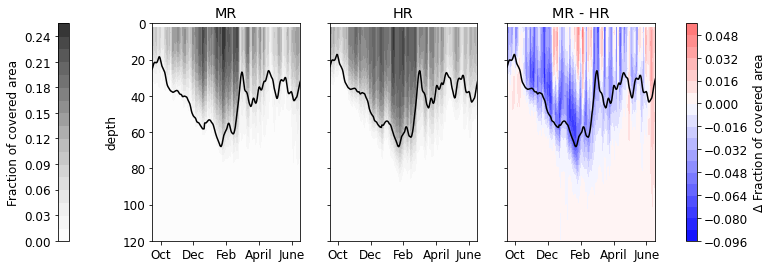

In [27]:
## Plot alongside each other

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# calculate total area covered by submesoscale fronts (up + down)
meso_area_tot = meso_res['area_up'] + meso_res['area_down']
subm_area_tot = subm_res['area_up'] + subm_res['area_down']

# calculate relative values. Remove first item as it is always 0
val_m = (meso_area_tot[:, 1:].T / total_area_meso)
val_m = val_m[:, :-1]
val_s = (subm_area_tot[:-1, 1:].T / total_area_subm)

# expand data to two years in order to move winter into center of plot
val_m = np.hstack((val_m, val_m))
val_s = np.hstack((val_s, val_s))
meso_mld_2y = np.hstack((meso_mld, meso_mld))
subm_mld_2y = np.hstack((subm_mld, subm_mld))

# build year (x values)
yr = np.linspace(0, 730, val_m.shape[1])
yr_mld = np.linspace(0, 730, meso_mld_2y.shape[0])

# plot data
cax_res = ax[0].contourf(yr, meso.z_level[1:], val_m, levels=20, vmin=0, vmax=0.3, cmap='Greys')
ax[1].contourf(yr, subm.z_level[1:], val_s, levels=20, vmin=0, vmax=0.3, cmap='Greys')
cax_diff = ax[2].contourf(yr, subm.z_level[1:], val_m - val_s, levels=20, vmin=-.1, vmax=.1, cmap='bwr')

# plot mlds
ax[1].plot(yr_mld, meso_mld_2y, color='k')
ax[0].plot(yr_mld, subm_mld_2y, color='k')
ax[2].plot(yr_mld, meso_mld_2y, color='k')

# add labels
ax[0].set_ylabel('depth')

# add xticks
xticks = np.array([270, 330, 390, 450, 510]) + 15
xticklabels = ['Oct', 'Dec', 'Feb', 'April', 'June']

# set the correct limits
for i in range(3):
    ax[i].set_xlim(270, 540)
    ax[i].set_ylim(120, 0)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels)

# titles
ax[0].set_title('MR')
ax[1].set_title('HR')
ax[2].set_title('MR - HR')

# colorbars
plt.colorbar(cax_res, ax=ax, location='left', label='Fraction of covered area')
plt.colorbar(cax_diff, ax=ax, location='right', label='$\\Delta$ Fraction of covered area')

plt.savefig('figures/result_subm_coverage.pdf')
plt.show()

### Intersection with eddies

#### pactcs15

In [28]:
# total area of submesoscale fronts intersecting with anticyclones
area_anti = subm_res['area_up_anti'] + subm_res['area_down_anti']
d_area_anti = np.sqrt(subm_res['d_area_up_anti']**2 + subm_res['d_area_down_anti']**2)

# total area of submesoscale fronts intersecting with cyclones
area_cycl = subm_res['area_up_cycl'] + subm_res['area_down_cycl']
d_area_cycl = np.sqrt(subm_res['d_area_up_cycl']**2 + subm_res['d_area_down_cycl']**2)

# total area of submesoscale fronts
area_tot = subm_res['area_up'] + subm_res['area_down']
d_area_tot = np.sqrt(subm_res['d_area_up']**2 + subm_res['d_area_down']**2)

# total area of submesoscale fronts not intersecting with any mesoscale eddy
area_none = area_tot - area_anti - area_cycl
d_area_none = np.sqrt((d_area_tot ** 2) + (d_area_anti ** 2) + (d_area_cycl ** 2))

# total area of mesoscale eddies
area_eddies = subm_res['area_cycl'] + subm_res['area_anti']
d_area_eddies = np.sqrt((subm_res['area_cycl']**2) + (subm_res['area_anti']**2))


In [29]:
def print_nice_mean_error(descr, x, dx):
    m, d = mean_with_error(x, dx)
    print('{:s}: {:1.3f} + {:1.3f}'.format(descr, m, d))

In [30]:
# area intersecting with cyclones relative to total area of submesoscale fronts
frac_cycl, d_frac_cycl = ratio_with_error(area_cycl, area_tot, d_area_cycl, d_area_tot)
print_nice_mean_error('Intersection with Cyclones', frac_cycl[:45, 8], d_frac_cycl[:45, 8])
# area intersecting with anticyclones relative to total area of submesoscale fronts
frac_anti, d_frac_anti = ratio_with_error(area_anti, area_tot, d_area_anti, d_area_tot)
print_nice_mean_error('Intersection with anticyclones', frac_anti[:45, 8], d_frac_anti[:45, 8])
# area not intersecting with eddies relative to total area of submesoscale fronts
frac_none, d_frac_none = ratio_with_error(area_none, area_tot, d_area_none, d_area_tot)
print_nice_mean_error('No intersection with eddies', frac_none[:45, 8], d_frac_none[:45, 8])
print('-'*20)
print('Sum:\t\t1')

Intersection with Cyclones: 0.103 + 0.004
Intersection with anticyclones: 0.145 + 0.004
No intersection with eddies: 0.751 + 0.014
--------------------
Sum:		1


/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:263: RuntimeWarning: invalid value encountered in true_divide
  rel = x/y
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:266: RuntimeWarning: invalid value encountered in true_divide
  ((dx/y)**2) +
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/utils.py:267: RuntimeWarning: invalid value encountered in true_divide
  ((dy*x/(y**2))**2)


In [31]:
print_nice_mean_error('Fraction of total area covered by eddies', area_eddies[:45]/total_area_subm, d_area_eddies[:45]/total_area_subm)
# area of cyclones relative to total area of mesoscale eddies (independent of submesoscale fronts)
frac_overall_cycl, d_frac_overall_cycl = ratio_with_error(subm_res['area_cycl'], area_eddies, subm_res['d_area_cycl'], d_area_eddies)
print_nice_mean_error('Relative amount of cyclones', frac_overall_cycl[:45], d_frac_overall_cycl[:45])

Fraction of total area covered by eddies: 0.313 + 0.034
Relative amount of cyclones: 0.631 + 0.073


In [32]:
# area intersecting with anticyclones relative to total area of anticyclones at 25m
frac_rel_to_anti, d_frac_rel_to_anti = ratio_with_error(area_anti[:, 8], subm_res['area_anti'], d_area_anti[:, 8], subm_res['d_area_anti'])
print_nice_mean_error('Fraction of anticyclones covered by subm. fronts', frac_rel_to_anti[:45], d_frac_rel_to_anti[:45])
# area intersecting with cyclones relative to total area of cyclones at 25m
frac_rel_to_cycl, d_frac_rel_to_cycl = ratio_with_error(area_cycl[:, 8], subm_res['area_cycl'], d_area_cycl[:, 8], subm_res['d_area_cycl'])
print_nice_mean_error('Fraction of cyclones covered by subm. fronts', frac_rel_to_cycl[:45], d_frac_rel_to_cycl[:45])

Fraction of anticyclones covered by subm. fronts: 0.200 + 0.009
Fraction of cyclones covered by subm. fronts: 0.083 + 0.005


#### pactcs30

In [33]:
# total area of submesoscale fronts intersecting with anticyclones
area_anti = meso_res['area_up_anti'] + meso_res['area_down_anti']
d_area_anti = np.sqrt(meso_res['d_area_up_anti']**2 + meso_res['d_area_down_anti']**2)

# total area of submesoscale fronts intersecting with cyclones
area_cycl = meso_res['area_up_cycl'] + meso_res['area_down_cycl']
d_area_cycl = np.sqrt(meso_res['d_area_up_cycl']**2 + meso_res['d_area_down_cycl']**2)

# total area of submesoscale fronts
area_tot = meso_res['area_up'] + meso_res['area_down']
d_area_tot = np.sqrt(meso_res['d_area_up']**2 + meso_res['d_area_down']**2)

# total area of submesoscale fronts not intersecting with any mesoscale eddy
area_none = area_tot - area_anti - area_cycl
d_area_none = np.sqrt((d_area_tot ** 2) + (d_area_anti ** 2) + (d_area_cycl ** 2))

# total area of mesoscale eddies
area_eddies = meso_res['area_cycl'] + meso_res['area_anti']
d_area_eddies = np.sqrt((meso_res['area_cycl']**2) + (meso_res['area_anti']**2))

In [34]:
# area intersecting with anticyclones relative to total area of anticyclones at 25m
frac_rel_to_anti, d_frac_rel_to_anti = ratio_with_error(area_anti[:, 8], meso_res['area_anti'], d_area_anti[:, 8], meso_res['d_area_anti'])
print_nice_mean_error('Fraction of anticyclones covered by subm. fronts', frac_rel_to_anti[:45], d_frac_rel_to_anti[:45])
# area intersecting with cyclones relative to total area of cyclones at 25m
frac_rel_to_cycl, d_frac_rel_to_cycl = ratio_with_error(area_cycl[:, 8], meso_res['area_cycl'], d_area_cycl[:, 8], meso_res['d_area_cycl'])
print_nice_mean_error('Fraction of cyclones covered by subm. fronts', frac_rel_to_cycl[:45], d_frac_rel_to_cycl[:45])

Fraction of anticyclones covered by subm. fronts: 0.117 + 0.005
Fraction of cyclones covered by subm. fronts: 0.070 + 0.006
